In [1]:
def get_load_data_from_TERNA(start_extr = '2019-01-01', end_extr = 'today', delay=1, bidding_zone = 'Nord'):
    
    print(f'START: {start_extr} - END: {end_extr} for {bidding_zone} bidding zone')
    start_function = time.time()
    
    # obtain token to access Terna's API
    key = 'YOUR KEY'
    secret = 'YOUR SECRET'

    token_url = "https://api.terna.it/public-api/access-token"
    
    token_payload = {'client_id': 'YOUR CLIENT ID',
                     'client_secret': 'YOUR CLIENT SECRET',
                     'grant_type': 'client_credentials'}
    
    token_headers = {'Content-Type': 'application/x-www-form-urlencoded'}

    token_response = requests.post(token_url, headers=token_headers, data=token_payload)
    token_data = token_response.json()

    if 'access_token' not in token_data:
        print("Failed to obtain access token")
        exit()

    access_token = token_data['access_token']
    
    print(f'Access token: {access_token} \n')
    
    time.sleep(3)
    
        # define how far back in time we want to go
    latest = pd.to_datetime(end_extr).date()
    earliest = pd.to_datetime(start_extr).date()
    date_span = pd.date_range(earliest, latest, freq='D')
    
    tmp = []
    wind_data = pd.DataFrame()
    
    chunk_size = 60
    u = 0
    while u < len(date_span):
        chunk_dates = date_span[u:u + chunk_size]
        if len(chunk_dates) > 0:
            
            url = f"https://api.terna.it/transparency/v1.0/gettotalload?dateFrom={chunk_dates.min().strftime('%d/%m/%Y')}&dateTo={chunk_dates.max().strftime('%d/%m/%Y')}&biddingZone={bidding_zone}"

            payload = {}
            headers = {'Authorization': f'Bearer {access_token}'}
            
            response = requests.request("GET", url, headers=headers, data=payload)
            
            if response.status_code==200:
                data = response.json()
                df_tmp = pd.DataFrame(data['totalLoad'])
                tmp.append(df_tmp)
            else:
                print('Error', response.text)
            
            print(chunk_dates.min().strftime('%d/%m/%Y'), chunk_dates.max().strftime('%d/%m/%Y'))
        
        time.sleep(delay)
        u += chunk_size
    source_data = pd.concat(tmp)
    
    end_function = time.time()
    elapsed_time = end_function - start_function
    print(f'Time taken to retrieve {len(source_data)} rows of load data: {int(elapsed_time)}s')
    
    return source_data

def parsing_load_data(df):
    df.dropna(inplace=True)
    df['Date'] = pd.to_datetime(load['Date'])
    df.rename(columns={'Total_Load_MW':'mw', 'Bidding_Zone':'area'}, inplace=True)
    df['mw'] = df.mw.astype('float')
    df['mwh'] = df.mw/4
    df.drop(columns=['Forecast_Total_Load_MW', 'mw'], inplace=True)
    df['month'] = df['Date'].dt.month
    df['time'] = df['Date'].dt.hour
    df['day'] = df['Date'].dt.date
    df['day_of_week'] = df.Date.dt.dayofweek
    df['is_saturday'] = False
    df.loc[df.day_of_week==5, 'is_saturday'] = True 
    df['is_sunday'] = False
    df.loc[df.day_of_week==6, 'is_sunday'] = True 
    it_holidays = holidays.Italy(years = df.Date.dt.year.unique()).keys()
    df['flg_holiday'] = False
    df.loc[df.day.isin(it_holidays), 'flg_holiday'] = True
    
    return df

def calculate_lags(df, n_lags=30, n_lags_w=15, type_ ='load'):
    span = range(24,24*n_lags,24)
    if type_ == 'load':
        for i in span:
            df[f'mwh_{int(i/24)}_before'] = df.mwh.shift(i)
    elif type_ == 'weather':
        span_w = range(24,24*n_lags_w,24)
        for i in span_w:
            df[f'temp_{int(i/24)}_before'] = df.temp.shift(i)
    else:
        print('Select a compatible type for the right kind of data you want to generate lagged values for (load or weather)')
    
    return df

def calculate_monthly_hourly_quantiles(df):
    quantiles = []

    for month in range(1,13):
        tmp = df[(df.month==month)]

        for hour in range(0,24):
            tmp_h = tmp[tmp.time==hour]
            for i in range(1, 11, 1):
                quant = tmp_h['mwh'].quantile(i/10)
                tmp_list = [month, hour, i, quant]
                quantiles.append(tmp_list)

    quantiles = pd.DataFrame(quantiles, columns=['month', 'time', 'quant_order', 'quant_value'])
    
    return quantiles

def calculate_residuals(forecast, actual):
    residuals = forecast.mwh-actual.mwh
    avg_residuals = residuals.mean()
    print(f'Average residual: {avg_residuals}')
    
    plt.figure(figsize=(13,6))
    plt.plot(residuals)
    plt.show()
    return residuals, avg_residuals

In [2]:
def get_weather_data(start, stop):
    cache_session = requests_cache.CachedSession('.cache', expire_after = -1)
    retry_session = retry(cache_session, retries = 5, backoff_factor = 0.2)
    openmeteo = openmeteo_requests.Client(session = retry_session)  
    
    url = "https://archive-api.open-meteo.com/v1/archive"
    
    params = {
        "latitude": 45.4643,
        "longitude": 9.1895,
        "start_date": start,
        "end_date": stop,
        "hourly": ["temperature_2m", "rain"],        
        "timezone": "auto"
    }
    responses = openmeteo.weather_api(url, params=params)
    
    response = responses[0]
    print(f"Coordinates {response.Latitude()}°N {response.Longitude()}°E")
    print(f"Timezone {response.Timezone()} {response.TimezoneAbbreviation()}")
    
    
    data = response.Hourly()
    data_temperature_2m = data.Variables(0).ValuesAsNumpy()
    data_rain = data.Variables(1).ValuesAsNumpy()

    data = {"date": pd.date_range(
        start = pd.to_datetime(data.Time(), unit = "s", utc = True),
        end = pd.to_datetime(data.TimeEnd(), unit = "s", utc = True),
        freq = pd.Timedelta(seconds = data.Interval()),
        inclusive = "left"
    )}
    data["temperature_2m"] = data_temperature_2m
    data["rain"] = data_rain

    data_df = pd.DataFrame(data = data)
    
    return data_df

In [3]:
# %pip install openmeteo-requests
# %pip install requests-cache retry-requests 

In [4]:
import pandas as pd
import numpy as np
import requests
import time
import matplotlib.pyplot as plt
# %pip install holidays
import holidays
import warnings
warnings.filterwarnings("ignore")

import openmeteo_requests
import requests_cache
from retry_requests import retry

In [5]:
plt.rcParams['figure.figsize'] = (13,5)

## Retrieve weather data with OpenMeteo API

In [6]:
start_date = '2021-01-01'
target_date = pd.to_datetime('today').date() + pd.DateOffset(days=0)
target_date

Timestamp('2024-06-06 00:00:00')

In [7]:
weather_data = get_weather_data(start_date, target_date.strftime('%Y-%m-%d'))

Coordinates 45.44815444946289°N 9.169279098510742°E
Timezone b'Europe/Rome' b'CEST'


In [8]:
if weather_data.isna().sum().sum() != 0:
    while weather_data.isna().sum().sum() != 0:
        [weather_data[col].fillna(weather_data[col].shift(24), inplace=True) for col in weather_data.columns]
else:
    print('There are 0 NaNs to be filled')

In [9]:
weather_data

,date,temperature_2m,rain
0,2020-12-31 22:00:00+00:00,-1.273000,0.0
1,2020-12-31 23:00:00+00:00,-1.123000,0.0
2,2021-01-01 00:00:00+00:00,-0.023000,0.0
3,2021-01-01 01:00:00+00:00,0.127000,0.0
4,2021-01-01 02:00:00+00:00,0.327000,0.0
...,...,...,...
30067,2024-06-06 17:00:00+00:00,20.126999,0.0
30068,2024-06-06 18:00:00+00:00,19.927000,0.0
30069,2024-06-06 19:00:00+00:00,17.976999,0.0
30070,2024-06-06 20:00:00+00:00,17.126999,0.0


In [10]:
weather_data['day'] = weather_data['date'].dt.date
weather_data['day'] = pd.to_datetime(weather_data['day'])
weather_data['month'] = weather_data['date'].dt.month
weather_data['time'] = weather_data['date'].dt.hour
weather_data['date'] = weather_data['date'].dt.tz_localize(None)

In [11]:
weather_data = weather_data[['date', 'day', 'month', 'time', 'temperature_2m']]
weather_data

,date,day,month,time,temperature_2m
0,2020-12-31 22:00:00,2020-12-31,12,22,-1.273000
1,2020-12-31 23:00:00,2020-12-31,12,23,-1.123000
2,2021-01-01 00:00:00,2021-01-01,1,0,-0.023000
3,2021-01-01 01:00:00,2021-01-01,1,1,0.127000
4,2021-01-01 02:00:00,2021-01-01,1,2,0.327000
...,...,...,...,...,...
30067,2024-06-06 17:00:00,2024-06-06,6,17,20.126999
30068,2024-06-06 18:00:00,2024-06-06,6,18,19.927000
30069,2024-06-06 19:00:00,2024-06-06,6,19,17.976999
30070,2024-06-06 20:00:00,2024-06-06,6,20,17.126999


In [12]:
date_range = pd.DataFrame(pd.date_range(start_date, target_date+pd.DateOffset(hours=23), freq='H'), columns=['date'])
date_range['day'] = date_range.date.dt.date
date_range['day'] = pd.to_datetime(date_range['day'])
date_range['month'] = date_range.date.dt.month
date_range['time'] = date_range.date.dt.hour
date_range

,date,day,month,time
0,2021-01-01 00:00:00,2021-01-01,1,0
1,2021-01-01 01:00:00,2021-01-01,1,1
2,2021-01-01 02:00:00,2021-01-01,1,2
3,2021-01-01 03:00:00,2021-01-01,1,3
4,2021-01-01 04:00:00,2021-01-01,1,4
...,...,...,...,...
30067,2024-06-06 19:00:00,2024-06-06,6,19
30068,2024-06-06 20:00:00,2024-06-06,6,20
30069,2024-06-06 21:00:00,2024-06-06,6,21
30070,2024-06-06 22:00:00,2024-06-06,6,22


In [13]:
weather_data = weather_data.merge(date_range[['date', 'day', 'month', 'time']], how='outer', on=['day', 'month', 'time'])
weather_data.loc[weather_data.date_x.isna(), 'date_x'] = weather_data.loc[weather_data.date_x.isna(), 'date_y']
weather_data = weather_data.sort_values(['date_x'], ascending = True)
while weather_data.temperature_2m.isna().sum() != 0:
    weather_data['temperature_2m'] = weather_data['temperature_2m'].fillna(weather_data['temperature_2m'].shift())
weather_data.drop(columns=['date_y'], inplace=True)

In [14]:
check = weather_data.groupby('day').day.count().reset_index(name='count_day')
days_to_eliminate = check[check.count_day!=24]
days_to_eliminate

,day,count_day
0,2020-12-31,2


In [15]:
weather_data_clean = weather_data[~weather_data.day.isin(days_to_eliminate.day.unique())]

In [16]:
weather_data_clean.rename(columns={'temperature_2m':'temp', 'date_x':'date'}, inplace=True)

In [17]:
true_start = weather_data_clean.date.min()
true_end = weather_data_clean.date.max()
print(true_start, true_end)

2021-01-01 00:00:00 2024-06-06 23:00:00


In [18]:
weather_data_clean.isna().sum()

date     0
day      0
month    0
time     0
temp     0
dtype: int64

In [19]:
n_lags_w = 15
weather_data_clean = calculate_lags(weather_data_clean, type_='weather')

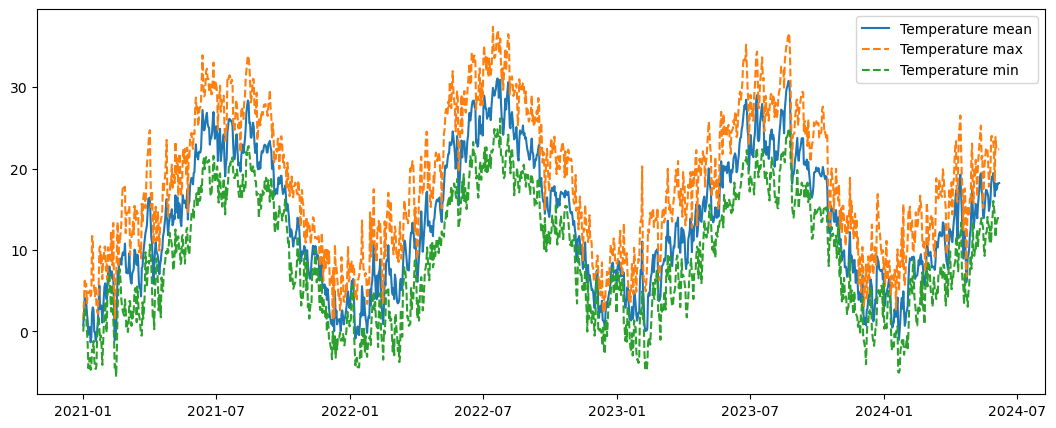

In [20]:
for op in ['mean', 'max', 'min']:
    if op == 'max' or op == 'min':
        linestyle = '--'
    elif op == 'mean':
        linestyle = 'solid'
    plt.plot(weather_data_clean.day.unique(), weather_data_clean.groupby('day').agg({'temp':op}), 
             linestyle = linestyle, label = f'Temperature {op}')

plt.legend()
plt.show()

<AxesSubplot:>

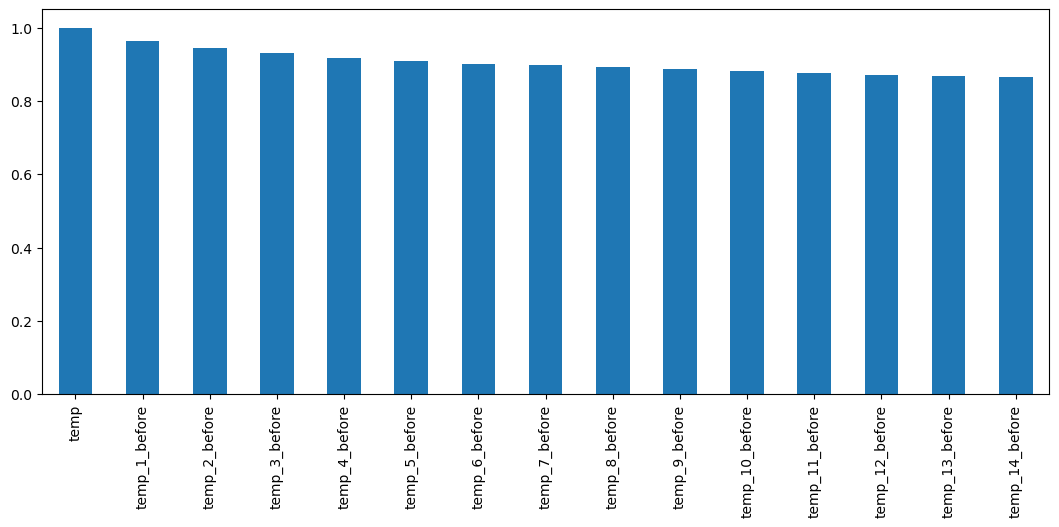

In [21]:
temp_columns = weather_data_clean.columns[weather_data_clean.columns.str.contains('temp')]
weather_data_clean[temp_columns].corr().iloc[0,:].plot(kind='bar')

## Data retrieval and data processing

In [22]:
bidding_zone = 'Nord'
load = get_load_data_from_TERNA(delay = 5, bidding_zone = bidding_zone, 
                                start_extr = true_start.strftime('%Y-%m-%d'), 
                                end_extr = '2024-06-04')
                                #end_extr = true_end.strftime('%Y-%m-%d'))

START: 2021-01-01 - END: 2024-06-04 for Nord bidding zone
Access token: tqu47658ndt2sty63b4bdzsh 

01/01/2021 01/03/2021
02/03/2021 30/04/2021
01/05/2021 29/06/2021
30/06/2021 28/08/2021
29/08/2021 27/10/2021
28/10/2021 26/12/2021
27/12/2021 24/02/2022
25/02/2022 25/04/2022
26/04/2022 24/06/2022
25/06/2022 23/08/2022
24/08/2022 22/10/2022
23/10/2022 21/12/2022
22/12/2022 19/02/2023
20/02/2023 20/04/2023
21/04/2023 19/06/2023
20/06/2023 18/08/2023
19/08/2023 17/10/2023
18/10/2023 16/12/2023
17/12/2023 14/02/2024
15/02/2024 14/04/2024
15/04/2024 04/06/2024
Time taken to retrieve 120092 rows of load data: 113s


In [23]:
load

,Date,Total_Load_MW,Forecast_Total_Load_MW,Bidding_Zone
0,2021-03-01 23:45:00,16936.031,16935.473,North
1,2021-03-01 23:30:00,17257.428,17471.135,North
2,2021-03-01 23:15:00,17608.465,17864.164,North
3,2021-03-01 23:00:00,17881.231,18176.919,North
4,2021-03-01 22:45:00,18043.69,18533.189,North
...,...,...,...,...
4891,2024-04-15 01:00:00,12483.423,12486.178,North
4892,2024-04-15 00:45:00,12858.87,12774.552,North
4893,2024-04-15 00:30:00,13017.869,12862.147,North
4894,2024-04-15 00:15:00,13231.542,13106.012,North


In [24]:
load = parsing_load_data(load)

In [25]:
load_hourly = load.groupby(['day', 'month', 'time', 'flg_holiday', 'is_saturday', 'is_sunday']).mwh.sum().reset_index()

In [26]:
load_hourly

,day,month,time,flg_holiday,is_saturday,is_sunday,mwh
0,2021-01-01,1,0,True,False,False,11979.33375
1,2021-01-01,1,1,True,False,False,11085.10825
2,2021-01-01,1,2,True,False,False,10197.47000
3,2021-01-01,1,3,True,False,False,9775.42225
4,2021-01-01,1,4,True,False,False,9726.83750
...,...,...,...,...,...,...,...
30015,2024-06-04,6,19,False,False,False,22278.95900
30016,2024-06-04,6,20,False,False,False,21648.33900
30017,2024-06-04,6,21,False,False,False,21283.05050
30018,2024-06-04,6,22,False,False,False,19694.26250


In [27]:
#fill in rows with the MWh from one hour before in case some hour is missing from Terna's data

start = load.day.min()
end = load.day.max() + pd.DateOffset(hours=23)
date_range = pd.DataFrame(pd.date_range(start, end, freq='H'), columns=['date'])
date_range['day'] = date_range.date.dt.date
date_range['month'] = date_range.date.dt.month
date_range['time'] = date_range.date.dt.hour

In [28]:
load_hourly = load_hourly.merge(date_range, how='outer', on=['day', 'month', 'time'])

In [29]:
load_hourly = load_hourly[['date', 'day', 'month', 'time', 'flg_holiday', 'is_saturday', 'is_sunday', 'mwh']]

In [30]:
date_range[~date_range.date.isin(load_hourly.date.unique())]

,date,day,month,time


In [31]:
len(date_range), len(load_hourly)

(30024, 30024)

In [32]:
load_hourly = load_hourly.sort_values(['date'], ascending = True)
load_hourly['mwh'] = load_hourly['mwh'].fillna(load_hourly['mwh'].shift())

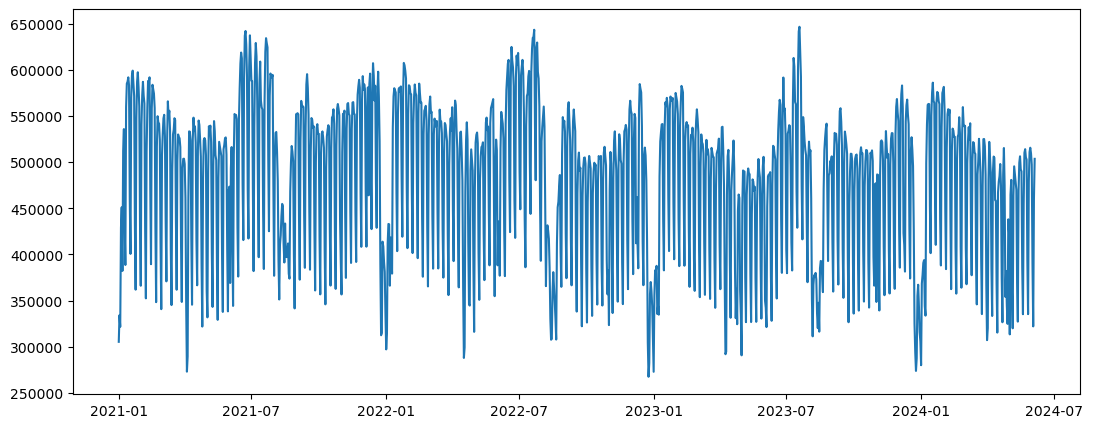

In [33]:
plt.figure(figsize=(13,5))
plt.plot(load_hourly.day.unique(), load_hourly.groupby('day').mwh.sum())

In [34]:
check = load_hourly.groupby(['day']).day.count().reset_index(name='count_hour')
check[check.count_hour!=24]

,day,count_hour


## Feature engineering

In [35]:
n_lags=30
load_hourly = calculate_lags(load_hourly, n_lags = n_lags, type_='load')

In [36]:
check = load_hourly.groupby(['day']).day.count().reset_index(name='count_hour')
check[check.count_hour!=24]

,day,count_hour


In [37]:
load_hourly

,date,day,month,time,flg_holiday,is_saturday,is_sunday,mwh,mwh_1_before,mwh_2_before,...,mwh_20_before,mwh_21_before,mwh_22_before,mwh_23_before,mwh_24_before,mwh_25_before,mwh_26_before,mwh_27_before,mwh_28_before,mwh_29_before
0,2021-01-01 00:00:00,2021-01-01,1,0,True,False,False,11979.33375,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2021-01-01 01:00:00,2021-01-01,1,1,True,False,False,11085.10825,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2021-01-01 02:00:00,2021-01-01,1,2,True,False,False,10197.47000,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2021-01-01 03:00:00,2021-01-01,1,3,True,False,False,9775.42225,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2021-01-01 04:00:00,2021-01-01,1,4,True,False,False,9726.83750,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30015,2024-06-04 19:00:00,2024-06-04,6,19,False,False,False,22278.95900,21422.07825,15529.94175,...,22850.37150,22812.48425,22354.00500,16314.99525,17554.24525,21111.84625,22024.06175,22546.97175,22643.88175,21724.99425
30016,2024-06-04 20:00:00,2024-06-04,6,20,False,False,False,21648.33900,20770.94125,15267.70850,...,22346.26750,22146.62375,21913.89425,16575.91600,17444.13625,20791.94625,21783.94950,22420.67850,22397.70200,21650.06225
30017,2024-06-04 21:00:00,2024-06-04,6,21,False,False,False,21283.05050,20388.00150,15132.82700,...,21373.93325,21183.09825,21076.71975,16401.17250,17143.19475,20280.11050,20976.32525,21474.17225,21322.42875,20860.42500
30018,2024-06-04 22:00:00,2024-06-04,6,22,False,False,False,19694.26250,18785.45300,14366.01900,...,19272.46475,19348.19825,19127.33200,15337.40575,16022.80900,18836.53875,19310.45375,19469.85725,19325.14775,18902.29100


In [38]:
quantiles = calculate_monthly_hourly_quantiles(load_hourly)

In [39]:
load_hourly = load_hourly.merge(quantiles, how='left', on=['month', 'time'])
load_hourly.columns

Index(['date', 'day', 'month', 'time', 'flg_holiday', 'is_saturday',
       'is_sunday', 'mwh', 'mwh_1_before', 'mwh_2_before', 'mwh_3_before',
       'mwh_4_before', 'mwh_5_before', 'mwh_6_before', 'mwh_7_before',
       'mwh_8_before', 'mwh_9_before', 'mwh_10_before', 'mwh_11_before',
       'mwh_12_before', 'mwh_13_before', 'mwh_14_before', 'mwh_15_before',
       'mwh_16_before', 'mwh_17_before', 'mwh_18_before', 'mwh_19_before',
       'mwh_20_before', 'mwh_21_before', 'mwh_22_before', 'mwh_23_before',
       'mwh_24_before', 'mwh_25_before', 'mwh_26_before', 'mwh_27_before',
       'mwh_28_before', 'mwh_29_before', 'quant_order', 'quant_value'],
      dtype='object')

In [40]:
check = load_hourly.groupby(['day']).day.count().reset_index(name='count_hour')
check[check.count_hour!=240]

,day,count_hour


In [41]:
load_hourly = load_hourly.pivot_table(index=['date', 'day', 'month', 'time', 'flg_holiday', 'is_saturday',
       'is_sunday', 'mwh', 'mwh_1_before', 'mwh_2_before',
       'mwh_3_before', 'mwh_4_before', 'mwh_5_before', 'mwh_6_before',
       'mwh_7_before', 'mwh_8_before', 'mwh_9_before', 'mwh_10_before',
       'mwh_11_before', 'mwh_12_before', 'mwh_13_before', 'mwh_14_before',
       'mwh_15_before', 'mwh_16_before', 'mwh_17_before', 'mwh_18_before',
       'mwh_19_before', 'mwh_20_before', 'mwh_21_before', 'mwh_22_before',
       'mwh_23_before', 'mwh_24_before', 'mwh_25_before', 'mwh_26_before',
       'mwh_27_before', 'mwh_28_before', 'mwh_29_before'], columns='quant_order', values='quant_value').reset_index()

In [42]:
load_hourly.columns.name = None
load_hourly.reset_index(drop=True, inplace=True)

for col in load_hourly.columns[-10:]:
    load_hourly.rename(columns={col:"quant_order_"+str(col)}, inplace=True)

In [43]:
check = load_hourly.groupby(['day']).day.count().reset_index(name='count_hour')
check[check.count_hour!=24]

,day,count_hour
57,2021-03-28,23
421,2022-03-27,23
785,2023-03-26,23
1156,2024-03-31,23


In [44]:
month_hour_mean = load_hourly.groupby(['month', 'time']).mwh.mean().reset_index()
month_hour_mean.rename(columns={'mwh':'monthly_hourly_mean'}, inplace=True)
load_hourly = load_hourly.merge(month_hour_mean, how='left',on=['month','time'])

In [45]:
load_hourly.columns

Index(['date', 'day', 'month', 'time', 'flg_holiday', 'is_saturday',
       'is_sunday', 'mwh', 'mwh_1_before', 'mwh_2_before', 'mwh_3_before',
       'mwh_4_before', 'mwh_5_before', 'mwh_6_before', 'mwh_7_before',
       'mwh_8_before', 'mwh_9_before', 'mwh_10_before', 'mwh_11_before',
       'mwh_12_before', 'mwh_13_before', 'mwh_14_before', 'mwh_15_before',
       'mwh_16_before', 'mwh_17_before', 'mwh_18_before', 'mwh_19_before',
       'mwh_20_before', 'mwh_21_before', 'mwh_22_before', 'mwh_23_before',
       'mwh_24_before', 'mwh_25_before', 'mwh_26_before', 'mwh_27_before',
       'mwh_28_before', 'mwh_29_before', 'quant_order_1', 'quant_order_2',
       'quant_order_3', 'quant_order_4', 'quant_order_5', 'quant_order_6',
       'quant_order_7', 'quant_order_8', 'quant_order_9', 'quant_order_10',
       'monthly_hourly_mean'],
      dtype='object')

In [46]:
load_hourly.isna().sum().sum()

0

<AxesSubplot:>

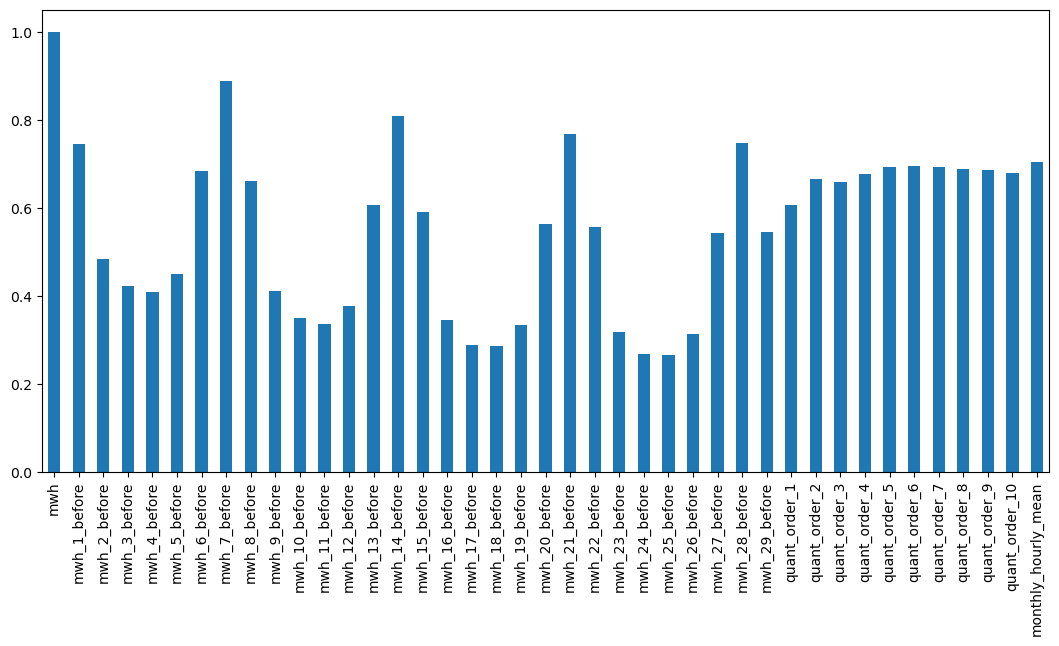

In [47]:
load_hourly[load_hourly.columns[7:]].corr().iloc[0].plot(kind='bar', figsize=(13,6))

## Merge load and weather data

In [48]:
check_load = load_hourly.groupby('day').day.count().reset_index(name='count_date')
check_load[check_load.count_date!=24]

,day,count_date
57,2021-03-28,23
421,2022-03-27,23
785,2023-03-26,23
1156,2024-03-31,23


In [49]:
check_weather = weather_data_clean.groupby('day').day.count().reset_index(name='count_date')
check_weather[check_weather.count_date!=24]

,day,count_date


In [50]:
load_hourly.date.min(), load_hourly.date.max()

(Timestamp('2021-01-30 00:00:00'), Timestamp('2024-06-04 23:00:00'))

In [51]:
weather_data_clean.date.min(), weather_data_clean.date.max()

(Timestamp('2021-01-01 00:00:00'), Timestamp('2024-06-06 23:00:00'))

In [52]:
load_hourly_ = load_hourly.merge(weather_data_clean, 
               how='left', on = ['date']).drop(columns=['day_y', 'month_y', 'time_y']).rename(columns={'day_x':'day',
                                                                                                    'month_x': 'month',
                                                                                                    'time_x':'time'})

In [53]:
[col for col in load_hourly_.columns]

['date',
 'day',
 'month',
 'time',
 'flg_holiday',
 'is_saturday',
 'is_sunday',
 'mwh',
 'mwh_1_before',
 'mwh_2_before',
 'mwh_3_before',
 'mwh_4_before',
 'mwh_5_before',
 'mwh_6_before',
 'mwh_7_before',
 'mwh_8_before',
 'mwh_9_before',
 'mwh_10_before',
 'mwh_11_before',
 'mwh_12_before',
 'mwh_13_before',
 'mwh_14_before',
 'mwh_15_before',
 'mwh_16_before',
 'mwh_17_before',
 'mwh_18_before',
 'mwh_19_before',
 'mwh_20_before',
 'mwh_21_before',
 'mwh_22_before',
 'mwh_23_before',
 'mwh_24_before',
 'mwh_25_before',
 'mwh_26_before',
 'mwh_27_before',
 'mwh_28_before',
 'mwh_29_before',
 'quant_order_1',
 'quant_order_2',
 'quant_order_3',
 'quant_order_4',
 'quant_order_5',
 'quant_order_6',
 'quant_order_7',
 'quant_order_8',
 'quant_order_9',
 'quant_order_10',
 'monthly_hourly_mean',
 'temp',
 'temp_1_before',
 'temp_2_before',
 'temp_3_before',
 'temp_4_before',
 'temp_5_before',
 'temp_6_before',
 'temp_7_before',
 'temp_8_before',
 'temp_9_before',
 'temp_10_before',
 '

In [54]:
load_hourly_[['mwh', 'temp']].corr()

,mwh,temp
mwh,1.000000,0.168407
temp,0.168407,1.000000


In [55]:
len(load_hourly_)

29324

In [56]:
check = load_hourly_.isna().sum()
check[check!=0]

Series([], dtype: int64)

### Create dataframe to forecast

In [57]:
n_days_to_predict = 1
start_pred = (load_hourly.day.max() + pd.DateOffset(days=1)).date()
end_pred = (start_pred + pd.DateOffset(days=n_days_to_predict)).date()
print(f'First day to predict: {start_pred}\nLast day to predict: {end_pred}')

df_to_predict = pd.DataFrame(pd.date_range(start_pred, (end_pred-pd.DateOffset(hours=1)), freq='H'), columns=['date'])
df_to_predict['day'] = df_to_predict.date.dt.date
df_to_predict['month'] = df_to_predict.date.dt.month
df_to_predict['time'] = df_to_predict.date.dt.hour
df_to_predict['flg_holiday'] = False
it_holidays = holidays.Italy(years = load.Date.dt.year.unique()).keys()
df_to_predict.loc[df_to_predict.day.isin(it_holidays), 'flg_holiday'] = True
df_to_predict['week_day'] = df_to_predict.date.dt.dayofweek
df_to_predict['is_saturday'] = False
df_to_predict['is_sunday'] = False
df_to_predict.loc[df_to_predict.week_day==5, 'is_saturday'] = True
df_to_predict.loc[df_to_predict.week_day==6, 'is_sunday'] = True
#df_to_predict.drop(columns=['week_day'], inplace=True)
df_to_predict['mwh'] = None 
df_to_predict['temp'] = None

span = range(24,24*n_lags,24)
for i in span:
    df_to_predict[f'mwh_{int(i/24)}_before'] = None
span_w = range(24,24*15,24)
for i in span_w:
    df_to_predict[f'temp_{int(i/24)}_before'] = None

First day to predict: 2024-06-05
Last day to predict: 2024-06-06


In [58]:
df_to_predict = df_to_predict.merge(quantiles, how='left', on=['month', 'time'])

In [59]:
df_to_predict.columns

Index(['date', 'day', 'month', 'time', 'flg_holiday', 'week_day',
       'is_saturday', 'is_sunday', 'mwh', 'temp', 'mwh_1_before',
       'mwh_2_before', 'mwh_3_before', 'mwh_4_before', 'mwh_5_before',
       'mwh_6_before', 'mwh_7_before', 'mwh_8_before', 'mwh_9_before',
       'mwh_10_before', 'mwh_11_before', 'mwh_12_before', 'mwh_13_before',
       'mwh_14_before', 'mwh_15_before', 'mwh_16_before', 'mwh_17_before',
       'mwh_18_before', 'mwh_19_before', 'mwh_20_before', 'mwh_21_before',
       'mwh_22_before', 'mwh_23_before', 'mwh_24_before', 'mwh_25_before',
       'mwh_26_before', 'mwh_27_before', 'mwh_28_before', 'mwh_29_before',
       'temp_1_before', 'temp_2_before', 'temp_3_before', 'temp_4_before',
       'temp_5_before', 'temp_6_before', 'temp_7_before', 'temp_8_before',
       'temp_9_before', 'temp_10_before', 'temp_11_before', 'temp_12_before',
       'temp_13_before', 'temp_14_before', 'quant_order', 'quant_value'],
      dtype='object')

In [60]:
df_to_predict = df_to_predict.fillna(np.random.random()).pivot_table(index=['date', 'day', 'month', 'time', 'flg_holiday', 'week_day',
       'is_saturday', 'is_sunday', 'mwh', 'temp', 'mwh_1_before',
       'mwh_2_before', 'mwh_3_before', 'mwh_4_before', 'mwh_5_before',
       'mwh_6_before', 'mwh_7_before', 'mwh_8_before', 'mwh_9_before',
       'mwh_10_before', 'mwh_11_before', 'mwh_12_before', 'mwh_13_before',
       'mwh_14_before', 'mwh_15_before', 'mwh_16_before', 'mwh_17_before',
       'mwh_18_before', 'mwh_19_before', 'mwh_20_before', 'mwh_21_before',
       'mwh_22_before', 'mwh_23_before', 'mwh_24_before', 'mwh_25_before',
       'mwh_26_before', 'mwh_27_before', 'mwh_28_before', 'mwh_29_before',
       'temp_1_before', 'temp_2_before', 'temp_3_before', 'temp_4_before',
       'temp_5_before', 'temp_6_before', 'temp_7_before', 'temp_8_before',
       'temp_9_before', 'temp_10_before', 'temp_11_before', 'temp_12_before',
       'temp_13_before', 'temp_14_before'], columns='quant_order', values='quant_value').reset_index()

df_to_predict.columns.name = None
df_to_predict.reset_index(drop=True, inplace=True)

for col in df_to_predict.columns[-10:]:
    df_to_predict.rename(columns={col:"quant_order_"+str(col)}, inplace=True)

In [61]:
df_to_predict = df_to_predict.merge(month_hour_mean, how='left',on=['month','time'])

In [62]:
df_to_predict.columns

Index(['date', 'day', 'month', 'time', 'flg_holiday', 'week_day',
       'is_saturday', 'is_sunday', 'mwh', 'temp', 'mwh_1_before',
       'mwh_2_before', 'mwh_3_before', 'mwh_4_before', 'mwh_5_before',
       'mwh_6_before', 'mwh_7_before', 'mwh_8_before', 'mwh_9_before',
       'mwh_10_before', 'mwh_11_before', 'mwh_12_before', 'mwh_13_before',
       'mwh_14_before', 'mwh_15_before', 'mwh_16_before', 'mwh_17_before',
       'mwh_18_before', 'mwh_19_before', 'mwh_20_before', 'mwh_21_before',
       'mwh_22_before', 'mwh_23_before', 'mwh_24_before', 'mwh_25_before',
       'mwh_26_before', 'mwh_27_before', 'mwh_28_before', 'mwh_29_before',
       'temp_1_before', 'temp_2_before', 'temp_3_before', 'temp_4_before',
       'temp_5_before', 'temp_6_before', 'temp_7_before', 'temp_8_before',
       'temp_9_before', 'temp_10_before', 'temp_11_before', 'temp_12_before',
       'temp_13_before', 'temp_14_before', 'quant_order_1', 'quant_order_2',
       'quant_order_3', 'quant_order_4', 'quan

In [63]:
for day in range(n_days_to_predict):
    beginning = time.time()
    
    day_to_forecast = pd.to_datetime(start_pred + pd.DateOffset(days=day)).date()
    mask_day = (df_to_predict.day == day_to_forecast)
    print(f'Preparing {day_to_forecast}')

    for enumeration, col in enumerate(df_to_predict.columns[10+day:10+len([i for i in span])]): #how many days to go back in time (lags) to see the corresponding MWh produced
        reference_day = (pd.to_datetime(load_hourly.day.max()- pd.DateOffset(days=enumeration)).date())
        
        print(f'For {col} --> reference day is {reference_day}')
        
        for hour in range(24):
            mask_day_hour = mask_day&(df_to_predict.time==hour)
            
            reference_hour = (load_hourly.time == hour)
            reference = (load_hourly.day == reference_day) & reference_hour
            
            if not load_hourly.loc[reference].empty:
                df_to_predict.loc[mask_day_hour, col] = load_hourly.loc[reference, 'mwh'].values[0]
                
            else:
                df_to_predict.loc[mask_day_hour, col] = 'CHECK DATA FROM TERNA' #proably missing data for corresponding reference day/hour
                
    termination = time.time()
    elapsed_time = termination - beginning
    print(f'Elapsed time for {day_to_forecast}: {elapsed_time:.2f}s \n')

Preparing 2024-06-05
For mwh_1_before --> reference day is 2024-06-04
For mwh_2_before --> reference day is 2024-06-03
For mwh_3_before --> reference day is 2024-06-02
For mwh_4_before --> reference day is 2024-06-01
For mwh_5_before --> reference day is 2024-05-31
For mwh_6_before --> reference day is 2024-05-30
For mwh_7_before --> reference day is 2024-05-29
For mwh_8_before --> reference day is 2024-05-28
For mwh_9_before --> reference day is 2024-05-27
For mwh_10_before --> reference day is 2024-05-26
For mwh_11_before --> reference day is 2024-05-25
For mwh_12_before --> reference day is 2024-05-24
For mwh_13_before --> reference day is 2024-05-23
For mwh_14_before --> reference day is 2024-05-22
For mwh_15_before --> reference day is 2024-05-21
For mwh_16_before --> reference day is 2024-05-20
For mwh_17_before --> reference day is 2024-05-19
For mwh_18_before --> reference day is 2024-05-18
For mwh_19_before --> reference day is 2024-05-17
For mwh_20_before --> reference day is

In [64]:
for day in range(n_days_to_predict):
    beginning = time.time()
    
    day_to_forecast = pd.to_datetime(start_pred + pd.DateOffset(days=day)).date()
    mask_day = (df_to_predict.day == day_to_forecast)
    print(f'Preparing {day_to_forecast}')

    for enumeration, col in enumerate(df_to_predict.columns[39+day:39+len([i for i in span_w])]): #how many days to go back in time (lags) to see the corresponding temperture
        reference_day = (pd.to_datetime(load_hourly_.day.max()- pd.DateOffset(days=enumeration)).date())
        
        print(f'For {col} --> reference day is {reference_day}')
        
        for hour in range(24):
            mask_day_hour = mask_day&(df_to_predict.time==hour)
            
            reference_hour = (load_hourly_.time == hour)
            reference = (load_hourly_.day == reference_day) & reference_hour
            
            if not load_hourly_.loc[reference].empty:
                df_to_predict.loc[mask_day_hour, col] = load_hourly_.loc[reference, 'temp'].values[0]
                
            else:
                df_to_predict.loc[mask_day_hour, col] = 'CHECK DATA FROM TERNA' #proably missing data for corresponding reference day/hour
                
    termination = time.time()
    elapsed_time = termination - beginning
    print(f'Elapsed time for {day_to_forecast}: {elapsed_time:.2f}s \n')

Preparing 2024-06-05
For temp_1_before --> reference day is 2024-06-04
For temp_2_before --> reference day is 2024-06-03
For temp_3_before --> reference day is 2024-06-02
For temp_4_before --> reference day is 2024-06-01
For temp_5_before --> reference day is 2024-05-31
For temp_6_before --> reference day is 2024-05-30
For temp_7_before --> reference day is 2024-05-29
For temp_8_before --> reference day is 2024-05-28
For temp_9_before --> reference day is 2024-05-27
For temp_10_before --> reference day is 2024-05-26
For temp_11_before --> reference day is 2024-05-25
For temp_12_before --> reference day is 2024-05-24
For temp_13_before --> reference day is 2024-05-23
For temp_14_before --> reference day is 2024-05-22
Elapsed time for 2024-06-05: 2.74s 



In [65]:
check = df_to_predict.isna().sum()
check[check!=0]

Series([], dtype: int64)

In [66]:
load_hourly_op = load_hourly_.copy()
load_hourly_op = pd.get_dummies(load_hourly_op, columns = ['month'], prefix = 'month')
load_hourly_op = pd.get_dummies(load_hourly_op, columns = ['time'], prefix = 'hour')

df_to_predict_op = df_to_predict.copy()
df_to_predict_op = pd.get_dummies(df_to_predict_op, columns = ['month'], prefix = 'month')
df_to_predict_op = pd.get_dummies(df_to_predict_op, columns = ['time'], prefix = 'hour')

In [67]:
len(df_to_predict_op.columns)

87

In [68]:
len(load_hourly_op.columns)

97

In [69]:
missing_cols = list(set(load_hourly_op.columns) - set(df_to_predict_op.columns))
print(missing_cols)

['month_7', 'month_11', 'month_12', 'month_10', 'month_8', 'month_2', 'month_5', 'month_1', 'month_9', 'month_3', 'month_4']


In [70]:
for col in missing_cols:
    df_to_predict_op[col] = False

In [71]:
df_to_predict_op = df_to_predict_op[load_hourly_op.columns]

In [72]:
df_to_predict_op.shape, load_hourly_op.shape

((24, 97), (29324, 97))

## Modelling

In [73]:
n_estimators = 2000
learning_rate = 0.01
subsample=0.75
max_depth=3

In [74]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

xgb_r = xgb.XGBRegressor(n_estimators = n_estimators, learning_rate = learning_rate, 
                         subsample=subsample, max_depth=max_depth, random_state=42)

In [75]:
load_hourly_op['day'] = pd.to_datetime(load_hourly_op.day)
df_to_predict_op['day'] = pd.to_datetime(df_to_predict_op.day)

In [76]:
load_hourly_op.dropna(inplace=True)

In [77]:
load_hourly_op['flg_holiday'] = load_hourly_op['flg_holiday'].astype(int)
load_hourly_op['is_saturday'] = load_hourly_op['is_saturday'].astype(int)
load_hourly_op['is_sunday'] = load_hourly_op['is_sunday'].astype(int)

df_to_predict_op['flg_holiday'] = df_to_predict_op['flg_holiday'].astype(int)
df_to_predict_op['is_saturday'] = df_to_predict_op['is_saturday'].astype(int)
df_to_predict_op['is_sunday'] = df_to_predict_op['is_sunday'].astype(int)

In [78]:
load_hourly_op.shape, df_to_predict_op.shape

((29324, 97), (24, 97))

In [99]:
predictions = []
for en, day in enumerate(df_to_predict_op.day.unique()):
    cols_nan_mwh = load_hourly_op.columns[6:6+en]
    cols_nan_temp = load_hourly_op.columns[47:47+en]
    cols_nan = list(cols_nan_mwh) + list(cols_nan_mwh)
    print(f'Selecting all columns for model trainig of {day}, except: {cols_nan}')
    train_tmp = load_hourly_op.drop(columns = cols_nan)
    train_tmp_x = train_tmp.drop(columns=['mwh', 'date', 'day', 'temp'])
    train_tmp_y = train_tmp['mwh']
    
    test_tmp = df_to_predict_op[df_to_predict_op.day == day].drop(columns=cols_nan)
    test_tmp_x = test_tmp.drop(columns=['mwh', 'date', 'day', 'temp'])
    #test_tmp_x.fillna(0, inplace=True)
    
    cols_change_type = test_tmp_x.filter(regex='mwh_.*_before').columns
    test_tmp_x[cols_change_type] = test_tmp_x[cols_change_type].astype(float)
    
    print(f'Train and test are ready with shape:\n', train_tmp_x.shape, test_tmp_x.shape, train_tmp_y.shape)
    
    model_xgb_tmp = xgb_r.fit(train_tmp_x, train_tmp_y)
    model_xgb_tmp = model_xgb_tmp.fit(train_tmp_x, train_tmp_y)
    predictions.append(model_xgb_tmp.predict(test_tmp_x))    
    
    print(f'Finished forecast for {day.date()} \n')

Selecting all columns for model trainig of 2024-06-05 00:00:00, except: []
Train and test are ready with shape:
 (29324, 93) (24, 93) (29324,)
Finished forecast for 2024-06-05 



In [100]:
predictions = pd.DataFrame(np.reshape(predictions, (n_days_to_predict*24, 1)), columns=['forecast'])

In [101]:
df_to_predict['mwh'] = predictions.forecast

In [83]:
start = start_pred.strftime('%Y-%m-%d')
end = (end_pred+pd.DateOffset(days=-1)).strftime('%Y-%m-%d')
mini_df = get_load_data_from_TERNA(start, end, delay=3, bidding_zone='Nord')

START: 2024-06-05 - END: 2024-06-05 for Nord bidding zone
Access token: 3dj6nq7umf4jvnm4xzhw97t4 

05/06/2024 05/06/2024
Time taken to retrieve 96 rows of load data: 6s


In [84]:
mini_df

mini_df.dropna(inplace=True)
mini_df['Date'] = pd.to_datetime(mini_df['Date'])
mini_df.rename(columns={'Total_Load_MW':'mw', 'Bidding_Zone':'area'}, inplace=True)

mini_df['mw'] = mini_df.mw.astype('float')
mini_df['mwh'] = mini_df.mw/4

mini_df.drop(columns=['Forecast_Total_Load_MW', 'mw'], inplace=True)
mini_df['month'] = mini_df['Date'].dt.month
mini_df['time'] = mini_df['Date'].dt.hour
mini_df['day'] = mini_df['Date'].dt.date

mini_df['day_of_week'] = mini_df.Date.dt.dayofweek
mini_df['is_saturday'] = False
mini_df.loc[mini_df.day_of_week==5, 'is_saturday'] = True 
mini_df['is_sunday'] = False
mini_df.loc[mini_df.day_of_week==6, 'is_sunday'] = True 

mini_df['flg_holiday'] = False
mini_df.loc[mini_df.day.isin(it_holidays), 'flg_holiday'] = True

mini_df_hourly = mini_df.groupby(['day', 'month', 'time', 'flg_holiday', 'is_saturday', 'is_sunday']).mwh.sum().reset_index()

,day,month,time,flg_holiday,is_saturday,is_sunday,mwh
0,2024-06-05,6,0,False,False,False,16490.87725
1,2024-06-05,6,1,False,False,False,15745.16625
2,2024-06-05,6,2,False,False,False,15298.84450
3,2024-06-05,6,3,False,False,False,15240.22675
4,2024-06-05,6,4,False,False,False,15375.03025
5,2024-06-05,6,5,False,False,False,15875.03925
6,2024-06-05,6,6,False,False,False,18572.39825
7,2024-06-05,6,7,False,False,False,21826.40850
8,2024-06-05,6,8,False,False,False,24339.52175
9,2024-06-05,6,9,False,False,False,25123.07450


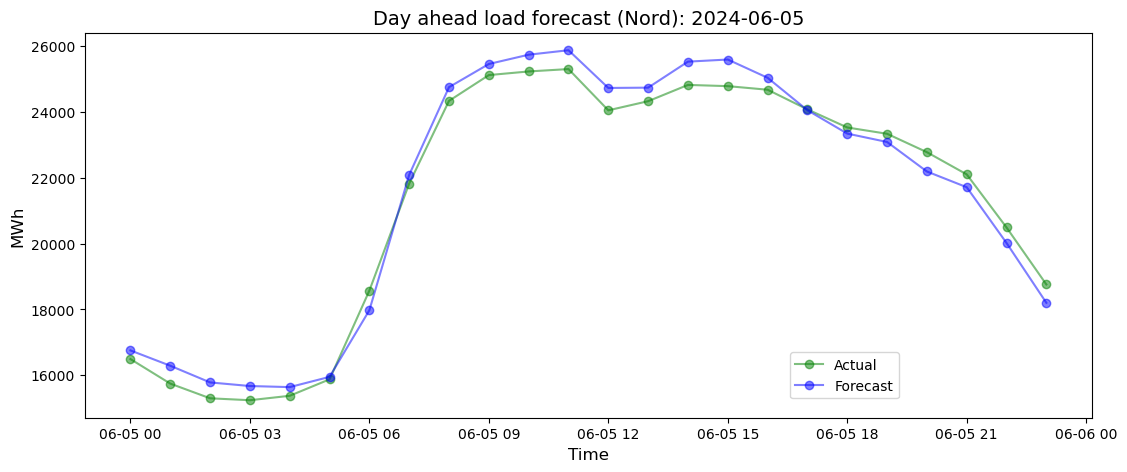

In [120]:
plt.figure(figsize=(13,5))

len_df = pd.date_range(pd.to_datetime(start), pd.to_datetime(end)+pd.DateOffset(hour=23), freq='H')

plt.plot(len_df, mini_df_hourly.mwh, label='Actual', color = 'g', marker = 'o', alpha = .5)
plt.plot(len_df, df_to_predict.mwh, label='Forecast', color = 'b', marker = 'o', alpha = .5)

plt.title(f'Day ahead load forecast ({bidding_zone}): {end}', fontsize=14)
plt.legend(loc=(0.7,0.05))
plt.xlabel('Time', fontsize=12)
plt.ylabel('MWh', fontsize=12)
plt.show()

In [113]:
mse = mean_squared_error(mini_df_hourly.mwh, df_to_predict.mwh)
rmse = np.sqrt(mse)
mape = mean_absolute_percentage_error(mini_df_hourly.mwh, df_to_predict.mwh)
print(f'RMSE: {round(rmse,1)}; MAPE: {mape*100}%')

RMSE: 465.7; MAPE: 2.02722105953686%
